In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
from ml_time_series import generate_envelope
import timeit
from datetime import datetime
from sklearn.externals import joblib
import matplotlib.pyplot as plt

%matplotlib notebook

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


In [2]:
import smtplib
from email.MIMEMultipart import MIMEMultipart
from email.MIMEText import MIMEText
from email.mime.image import MIMEImage

def send_email(text, img=False ,toaddr='jorgeluizjk@gmail.com'):
    fromaddr = 'ohperaml@gmail.com'
    passw = 'ohperaml11'
    msg = MIMEMultipart()
    msg['From'] = fromaddr
    msg['To'] = toaddr
    msg['Subject'] = "Jupyter - Processing completed"

    body = 'Processing completed\n' + text
    msg.attach(MIMEText(body, 'plain'))
    
    if img!=False:
        img_data = open(img, 'rb').read()
        image = MIMEImage(img_data, name=os.path.basename(img))
        msg.attach(image)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(fromaddr, passw)
    text = msg.as_string()
    server.sendmail(fromaddr, toaddr, text)
    server.quit()

---
## Filtering

In [3]:
def filter_signal(emg, low_pass=10., sfreq=2000., high_band=20., low_band=450.):
    """
    emg: EMG data
    high: high-pass cut off frequency
    low: low-pass cut off frequency
    sfreq: sampling frequency
    """
    
    # normalise cut-off frequencies to sampling frequency
    high_band = high_band/(sfreq/2)
    low_band = low_band/(sfreq/2)
    
    # create bandpass filter for EMG
    b1, a1 = sp.signal.butter(4, [high_band,low_band], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sp.signal.filtfilt(b1, a1, emg)    
    
    # process EMG signal: rectify
    emg_rectified = abs(emg_filtered)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope
    low_pass = low_pass/sfreq
    b2, a2 = sp.signal.butter(4, low_pass, btype='lowpass')
    emg_envelope = sp.signal.filtfilt(b2, a2, emg_rectified)
    
    return emg_envelope

In [4]:
def plot_fremg(FILE_,Xc):    
    
    fig = plt.figure()
    ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
    plt.plot(Xc[:, 0], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 1')
    plt.show()
    
    # pass sharey=ax1 to ensure the two subplots share the same y axis
    ax2 = plt.subplot(4, 1, 2, sharey=ax1).xaxis.set_visible(False)
    plt.plot(Xc[:, 1], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 2')
    plt.show()
    
    ax3 = plt.subplot(4, 1, 3, sharey=ax1).xaxis.set_visible(False)
    plt.plot(Xc[:, 2], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 3')
    plt.show()
    
    ax4 = plt.subplot(4, 1, 4, sharey=ax1)
    plt.plot(Xc[:, 3], linewidth=0.2)
    plt.xlabel('Samples')
    plt.ylabel('mV').set_rotation(0)
    plt.title('Channel 4')
    plt.show()
    
    #fig_name = FILE_+'_filtered'+str(180)+'.png'
    fig.set_size_inches(w=10,h=7)
    #fig.savefig('./graphs/'+fig_name)

In [5]:
def plot_fft(Xc, fs):
    X =np.abs(np.fft.fft(Xc[:, 0]))
    f =np.linspace(0, fs,Xc[:, 0].shape[0])
    fig = plt.figure()
    ax1 = plt.subplot(4, 1, 1).xaxis.set_visible(False)
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel('Frequency')
    plt.ylabel('mV').set_rotation(0)
    plt.title('FFT')

    # pass sharey=ax1 to ensure the two subplots share the same y axis
    X =np.abs(np.fft.fft(Xc[:, 1]))
    f =np.linspace(0, fs,Xc[:, 1].shape[0])
    ax2 = plt.subplot(4, 1, 2, sharey=ax1).xaxis.set_visible(False)
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel('Frequency')
    plt.ylabel('mV').set_rotation(0)
    #plt.title('Channel 2')

    X =np.abs(np.fft.fft(Xc[:, 2]))
    f =np.linspace(0, fs,Xc[:, 2].shape[0])
    ax3 = plt.subplot(4, 1, 3, sharey=ax1).xaxis.set_visible(False)
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel('Frequency')
    plt.ylabel('mV').set_rotation(0)
    #plt.title('Channel 3')
    
    X =np.abs(np.fft.fft(Xc[:, 3]))
    f =np.linspace(0, fs,Xc[:, 3].shape[0])
    ax4 = plt.subplot(4, 1, 4, sharey=ax1)
    plt.plot(f,X, linewidth=0.2)
    plt.xlabel('Frequency')
    plt.ylabel('mV').set_rotation(0)
    #plt.title('Channel 4')
    
    fig.set_size_inches(w=10,h=7)

# Mão Direita

In [6]:
FILE_ = ['gait_uz', 'grip_d_uz', 'grip_e_uz']

X = np.genfromtxt('DB_PKS/'+FILE_[1]+'.txt', delimiter=",", skip_header=1, max_rows=40000, usecols=(1,2,3,4))

<IPython.core.display.Javascript object>


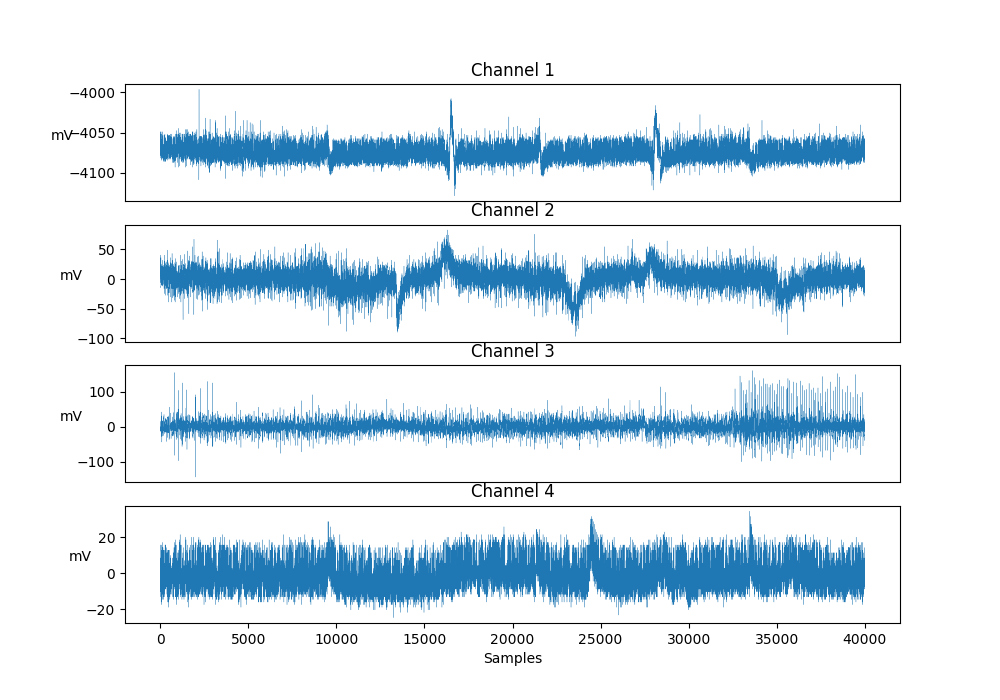

In [7]:
plot_fremg(FILE_[1],X)

<IPython.core.display.Javascript object>


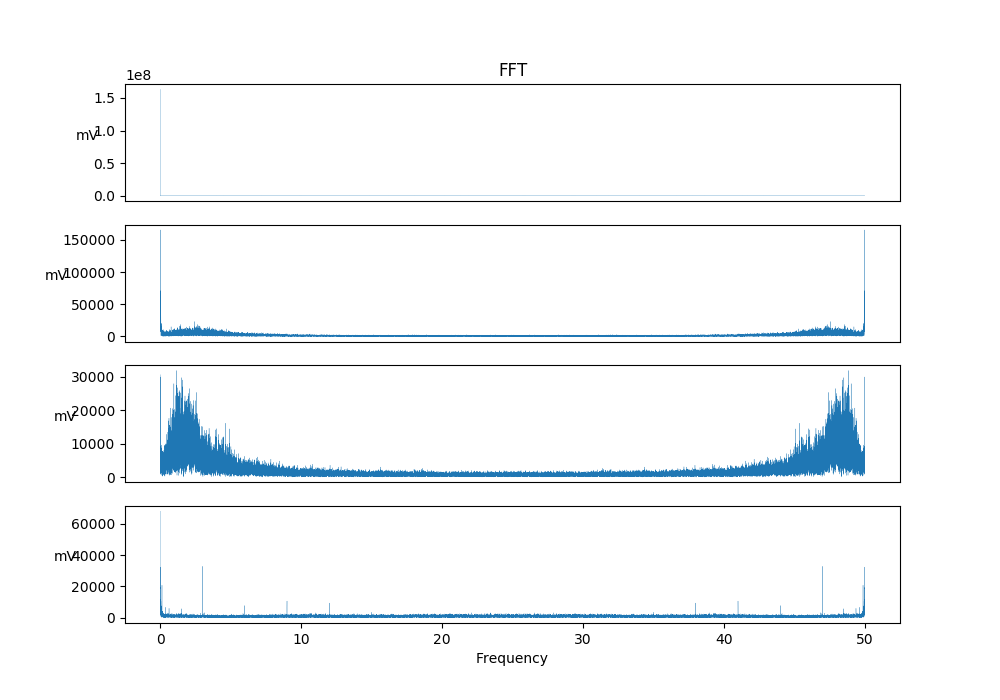

In [8]:
plot_fft(X, 50)

<IPython.core.display.Javascript object>


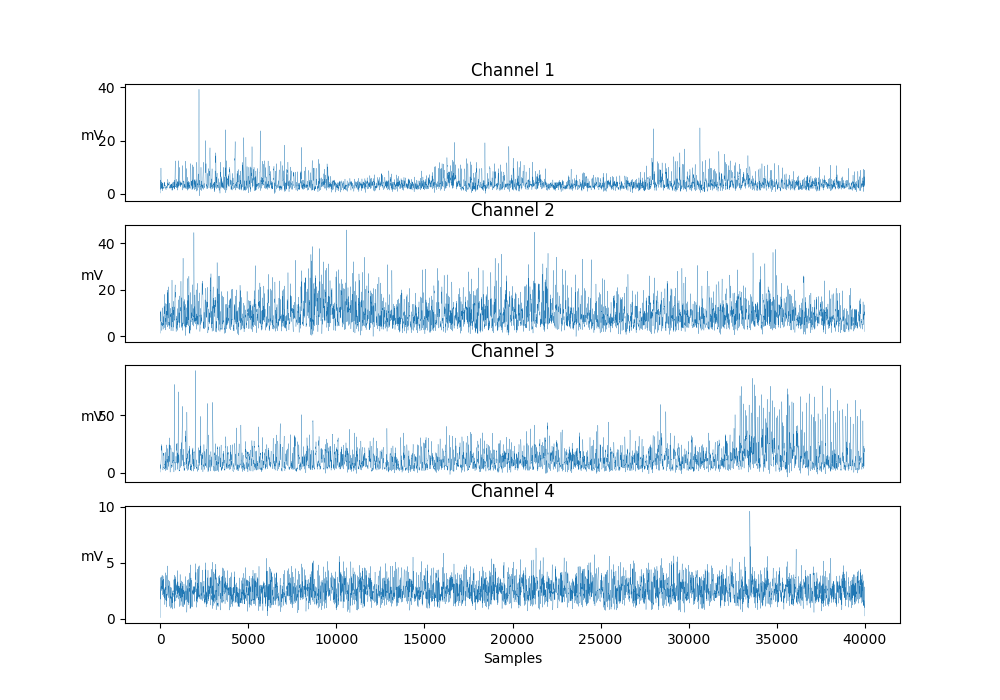

In [9]:
 for i in range(X.shape[1]):
    #Xc = filter_signal(X[:, i], low_pass=180)
    #plot_fremg(FILE_[1], Xc)
    
        if i == 0:
            Xc = filter_signal(X[:, i], low_pass=180)
            #plot_fremg(FILE_, Xc)
        else:
            Xcp = filter_signal(X[:, i], low_pass=180)
            #plot_fremg(FILE_, Xcp)
            Xc = np.vstack((Xc,Xcp))
Xc = np.transpose(Xc)
plot_fremg(FILE_[1], Xc)

# Mão Esquerda

<IPython.core.display.Javascript object>


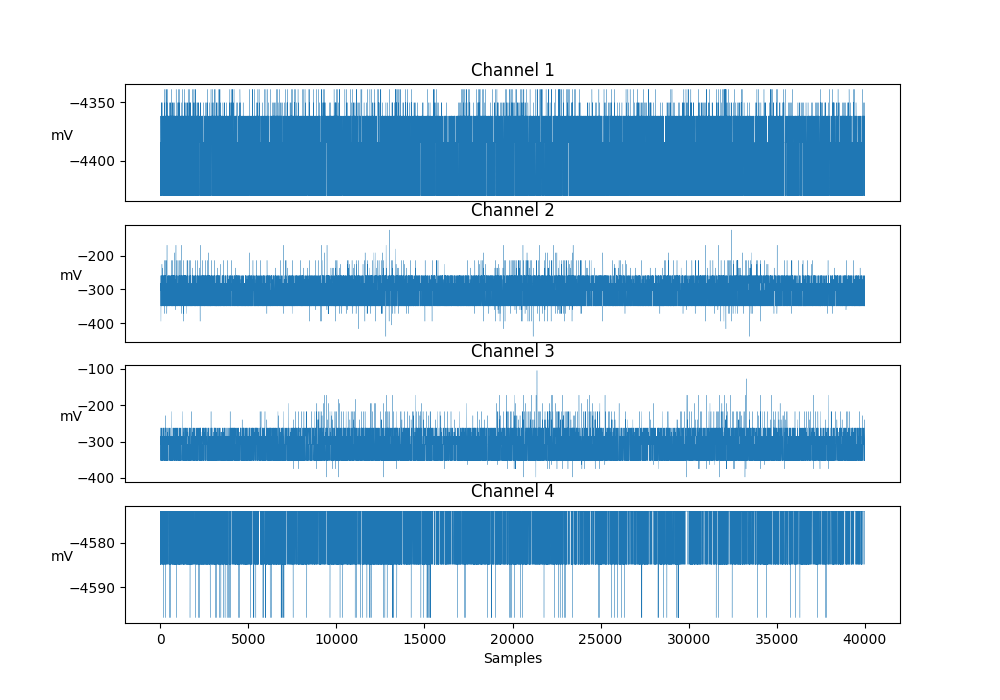

In [10]:
X = np.genfromtxt('DB_PKS/'+FILE_[2]+'.txt', delimiter=",", skip_header=1, max_rows=40000, usecols=(1,2,3,4))
plot_fremg(FILE_[1],X)

<IPython.core.display.Javascript object>


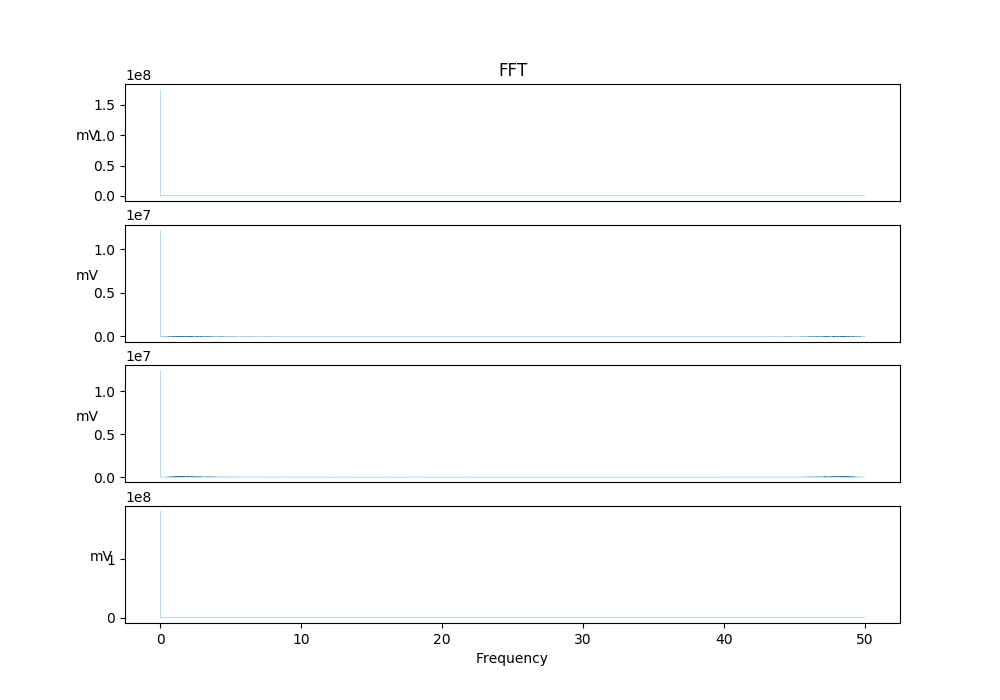

In [11]:
plot_fft(X, 50)

<IPython.core.display.Javascript object>


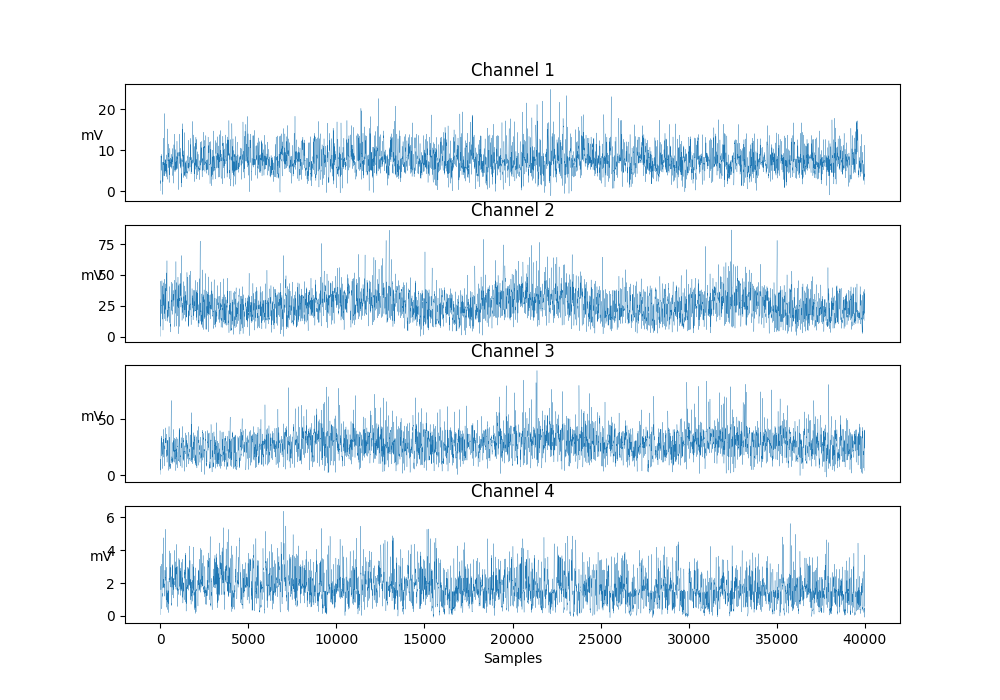

In [12]:
 for i in range(X.shape[1]):
    #Xc = filter_signal(X[:, i], low_pass=180)
    #plot_fremg(FILE_[1], Xc)
    
        if i == 0:
            Xc = filter_signal(X[:, i], low_pass=180)
            #plot_fremg(FILE_, Xc)
        else:
            Xcp = filter_signal(X[:, i], low_pass=180)
            #plot_fremg(FILE_, Xcp)
            Xc = np.vstack((Xc,Xcp))
Xc = np.transpose(Xc)
plot_fremg(FILE_[2], Xc)

---

## Processing

In [10]:
def proccess_data(FILE_,DATA,NUM_SAMPLES,LABEL):

    X = np.genfromtxt('DB_GAIT/'+FILE_+'.txt', delimiter=",", usecols=(1,2,3,4))
    
    for i in range(X.shape[1]):
        if i == 0:
            Xc = filter_signal(X[:, i], low_pass=180)
            #plot_fremg(FILE_, Xc)
        else:
            Xcp = filter_signal(X[:, i], low_pass=180)
            #plot_fremg(FILE_, Xcp)
            Xc = np.vstack((Xc,Xcp))
    Xc = np.transpose(Xc)
    plot_fremg(FILE_, Xc)
    
    print '\nXc shape ', Xc.shape
    
    #Create temporal serie
    Xc = generate_envelope(Xc, NUM_SAMPLES)
    print 'Xc temporal-serie shape ', Xc.shape
    
    #Labeling the type of movement
    C = (np.ones(len(Xc))*LABEL).reshape((len(Xc),1))
    Xc = np.hstack((Xc.reshape(Xc.shape),C.reshape((len(Xc),1))))
    print 'Xc labeled shape ', Xc.shape
    
    # Salving in file on the folder <classifier_data>
    np.save('./preproc_filtered_data/'+FILE_, Xc, allow_pickle=False)
    print FILE_+'.npy'
    
    DATA.append(FILE_+'.npy')

---

In [9]:
files_w = ['data_w_1', 'data_w_2', 'data_w_3', 'data_w_4', 'data_w_5', 'data_w_6', 'data_w_7', 'data_w_8', 'data_w_9', 
           'data_w_10', 'data_w_11', 'data_w_12']
files_r = ['data_r_1', 'data_r_2', 'data_r_3', 'data_r_4', 'data_r_5', 'data_r_6', 'data_r_7', 'data_r_8', 'data_r_9', 
           'data_r_10', 'data_r_11', 'data_r_12']
files_us = ['data_us_1', 'data_us_2', 'data_us_3', 'data_us_4', 'data_us_5', 'data_us_6', 'data_us_7', 'data_us_8', 
            'data_us_9', 'data_us_10', 'data_us_11', 'data_us_12']
files_ds = ['data_ds_1', 'data_ds_2', 'data_ds_3', 'data_ds_4', 'data_ds_5', 'data_ds_6', 'data_ds_7', 'data_ds_8', 
            'data_ds_9', 'data_ds_10', 'data_ds_11', 'data_ds_12']

NUM_SAMPLES = 500 #Envelope size.

DATA = []

start = timeit.default_timer()

#Passing the data to processing and labeling them.
for i in files_w:
    proccess_data(i,DATA,NUM_SAMPLES,0)

for i in files_r:
    proccess_data(i,DATA,NUM_SAMPLES,1)

for i in files_us:
    proccess_data(i,DATA,NUM_SAMPLES,2)

for i in files_ds:
    proccess_data(i,DATA,NUM_SAMPLES,3)

print DATA

stop = timeit.default_timer()
ti = stop - start 

send_email('\n Total time for enveloping: %.2f min' % (ti/60))
print ('Total time for enveloping: %.2f min' % (ti/60))

IOError: DB_GAIT/data_w_1.txt not found.

In [92]:
%%bash
paplay /usr/share/sounds/freedesktop/stereo/complete.oga

['data_w_1.npy', 'data_w_2.npy', 'data_w_3.npy', 'data_w_4.npy', 'data_w_5.npy', 'data_w_6.npy', 'data_w_7.npy', 'data_w_8.npy', 'data_w_9.npy', 'data_w_10.npy', 'data_w_11.npy', 'data_w_12.npy', 'data_r_1.npy', 'data_r_2.npy', 'data_r_3.npy', 'data_r_4.npy', 'data_r_5.npy', 'data_r_6.npy', 'data_r_7.npy', 'data_r_8.npy', 'data_r_9.npy', 'data_r_10.npy', 'data_r_11.npy', 'data_r_12.npy', 'data_us_1.npy', 'data_us_2.npy', 'data_us_3.npy', 'data_us_4.npy', 'data_us_5.npy', 'data_us_6.npy', 'data_us_7.npy', 'data_us_8.npy', 'data_us_9.npy', 'data_us_10.npy', 'data_us_11.npy', 'data_us_12.npy', 'data_ds_1.npy', 'data_ds_2.npy', 'data_ds_3.npy', 'data_ds_4.npy', 'data_ds_5.npy', 'data_ds_6.npy', 'data_ds_7.npy', 'data_ds_8.npy', 'data_ds_9.npy', 'data_ds_10.npy', 'data_ds_11.npy', 'data_ds_12.npy']

In [119]:
DATA = ['data_w_1.npy', 'data_w_2.npy', 'data_w_3.npy', 'data_w_4.npy', 'data_w_5.npy', 'data_w_6.npy', 'data_w_7.npy', 
        'data_r_1.npy', 'data_r_2.npy', 'data_r_3.npy', 'data_r_4.npy', 'data_r_5.npy', 'data_r_6.npy', 'data_r_7.npy', 
        'data_us_1.npy', 'data_us_2.npy', 'data_us_3.npy', 'data_us_4.npy', 'data_us_5.npy', 'data_us_6.npy', 
        'data_us_7.npy', 'data_ds_1.npy', 'data_ds_2.npy', 'data_ds_3.npy', 'data_ds_4.npy', 'data_ds_5.npy', 
        'data_ds_6.npy', 'data_ds_7.npy']

len(DATA)

28

DATA = ['data_w_1.npy', 'data_w_2.npy', 'data_w_3.npy', 'data_w_4.npy', 'data_w_5.npy', 'data_w_6.npy', 'data_w_7.npy', 'data_w_8.npy', 'data_w_9.npy', 'data_w_10.npy', 'data_w_11.npy', 'data_w_12.npy', 'data_r_1.npy', 'data_r_2.npy', 'data_r_3.npy', 'data_r_4.npy', 'data_r_5.npy', 'data_r_6.npy', 'data_r_7.npy', 'data_r_8.npy', 'data_r_9.npy', 'data_r_10.npy', 'data_r_11.npy', 'data_r_12.npy', 'data_us_1.npy', 'data_us_2.npy', 'data_us_3.npy', 'data_us_4.npy', 'data_us_5.npy', 'data_us_6.npy', 'data_us_7.npy', 'data_us_8.npy', 'data_us_9.npy', 'data_us_10.npy', 'data_us_11.npy', 'data_us_12.npy', 'data_ds_1.npy', 'data_ds_2.npy', 'data_ds_3.npy', 'data_ds_4.npy', 'data_ds_5.npy', 'data_ds_6.npy', 'data_ds_7.npy', 'data_ds_8.npy', 'data_ds_9.npy', 'data_ds_10.npy', 'data_ds_11.npy', 'data_ds_12.npy']


In [120]:
start = timeit.default_timer()

Xc = np.load("preprocessed_data/"+DATA[0])
for i in DATA[1:]:
    Xc = np.vstack((Xc,np.load("preprocessed_data/"+i))) 
    
stop = timeit.default_timer()
ti = stop - start 
print ('Tempo total para o envelopamento: %.2f min' % (ti/60))
Xc.shape

Tempo total para o envelopamento: 0.36 min


(134056, 2001)

In [121]:
np.save('./preproc_filtered_data/row_data', Xc, allow_pickle=False)
print 'Xc saved as row_data.npy'

Xc saved as row_data.npy


# --- Start ---

In [122]:
Xc = np.load("preproc_filtered_data/row_data.npy")

In [123]:
Xc.shape

(134056, 2001)

In [124]:
X = Xc[:,0:(Xc.shape[1]-2)]

yz = Xc[:,[(Xc.shape[1]-1)]]
y = np.array([])
for i in range(len(yz)):
    y = np.hstack((y,yz[i]))

X.shape, y.shape

((134056, 1999), (134056,))

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [126]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [127]:
print X_train_std.shape

(93839, 1999)


# Random Forest Classifier

In [128]:
#Training
print 'Training process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600, n_jobs=4, max_features='log2', 
                             warm_start=True)
rfc = rfc.fit(X_train_std, y_train)

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
send_email(('\n Training process: \n %s \n %s \n %s \n' % (slt, flt, tc)))

Training process:
Started at 12:36:58
Finished at 12:41:45
Total time 4.77 min


In [129]:
#Test
print 'Predicting process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

y_pred = rfc.predict(X_test_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_test, y_pred)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
print acc
send_email(('\n Predict process: \n %s \n %s \n %s \n %s' % (slt, flt, tc, acc)))

Predicting process:
Started at 12:41:49
Finished at 12:42:02
Total time 0.21 min
ClassifyRF accuracy:---------->97.18 %


In [130]:
#Save the classifier to file
joblib.dump(rfc, 'rfc.pkl') 


['rfc.pkl']

In [131]:
#Load the classifier from file
rfc = joblib.load('rfc.pkl')

## Validation

In [148]:
DATAV = ['data_w_11.npy', 'data_r_11.npy', 'data_us_11.npy', 'data_ds_11.npy']

Xc = np.load("preprocessed_data/"+DATAV[0])
for i in DATAV[1:]:
    Xc = np.vstack((Xc,np.load("preprocessed_data/"+i)))
    
Xvalid = Xc[:,0:(Xc.shape[1]-2)]

yz = Xc[:,[(Xc.shape[1]-1)]]
yvalid = np.array([])
for i in range(len(yz)):
    yvalid = np.hstack((yvalid,yz[i]))

print Xvalid.shape, yvalid.shape

(21008, 1999) (21008,)


In [149]:
#Validation
print 'Validation process:'
slt = ('Started at %s' % datetime.now().strftime('%H:%M:%S'))
print slt
sc = timeit.default_timer()

std.fit(X_train)
X_valid_std = std.transform(Xvalid)
y_pred = rfc.predict(X_valid_std)
from sklearn.metrics import accuracy_score
acc = ('ClassifyRF accuracy:---------->%.2f %%' % (accuracy_score(y_pred, yvalid)*100))

fc = timeit.default_timer()
flt = ('Finished at %s' % datetime.now().strftime('%H:%M:%S'))
print flt
tc = ('Total time %.4s min' % ((fc - sc)/60))
print tc
print acc
send_email(('\n Validation process: \n %s \n %s \n %s \n %s' % (slt, flt, tc, acc)))

Validation process:
Started at 13:21:21
Finished at 13:21:41
Total time 0.33 min
ClassifyRF accuracy:---------->62.17 %


ClassifyRF 8  accuracy:---------->54.65 %

ClassifyRF 9  accuracy:---------->36.51 %

ClassifyRF 10 accuracy:---------->60.83 %

ClassifyRF 11 accuracy:---------->62.17 %

ClassifyRF 12 accuracy:---------->53.31%

ClassifyRF 8  accuracy:---------->36.00 %

ClassifyRF 9  accuracy:---------->50.07 %

ClassifyRF 10 accuracy:---------->60.37 %

ClassifyRF 11 accuracy:---------->59.10 %

ClassifyRF 12 accuracy:---------->50.10 %

## Confusion Matrix

<IPython.core.display.Javascript object>


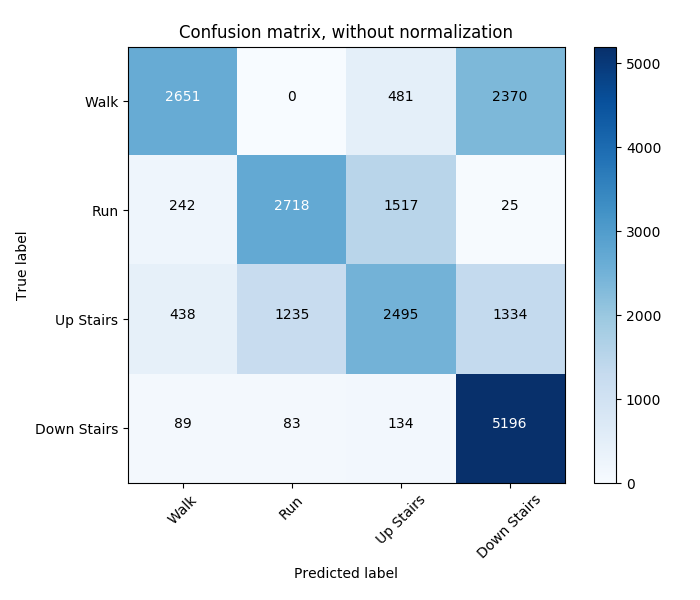

Confusion matrix, without normalization
[[2651    0  481 2370]
 [ 242 2718 1517   25]
 [ 438 1235 2495 1334]
 [  89   83  134 5196]]


<IPython.core.display.Javascript object>


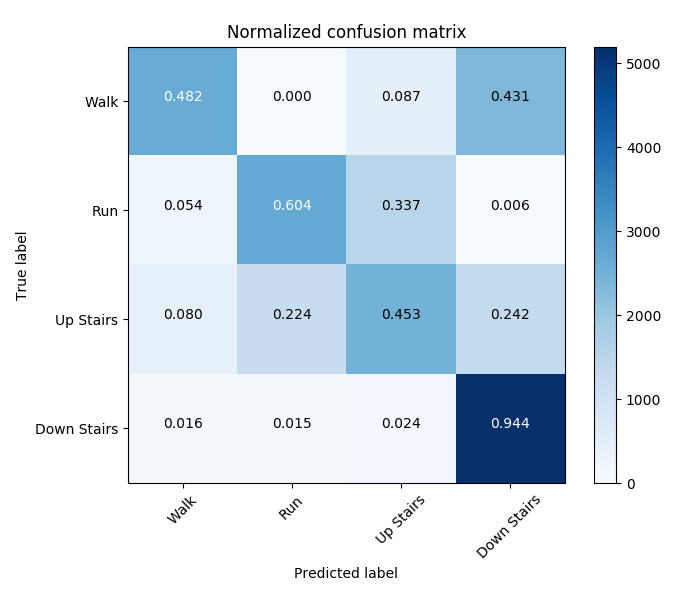

Normalized confusion matrix
[[ 0.48  0.    0.09  0.43]
 [ 0.05  0.6   0.34  0.01]
 [ 0.08  0.22  0.45  0.24]
 [ 0.02  0.02  0.02  0.94]]


In [155]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

%matplotlib notebook
class_names = np.array(['Walk', 'Run', 'Up Stairs', 'Down Stairs'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, ('%.3f' % cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    print(cm)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(yvalid, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.set_size_inches(w=7,h=6)

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig_name = 'cm.png'
fig.set_size_inches(w=7,h=6)
fig.savefig(fig_name)

plt.show()

In [151]:
cm = confusion_matrix(yvalid, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
TPa = float(cm[0][0])
Eab = float(cm[0][1])
Eac = float(cm[0][2])
#####################
Eba = float(cm[1][0])
TPb = float(cm[1][1])
Ebc = float(cm[1][2])
#####################
Eca = float(cm[2][0])
Ecb = float(cm[2][1])
TPc = float(cm[2][2])

Pa = TPa/(TPa+Eba+Eca)
Pb = TPb/(TPb+Eab+Ecb)
Pc = TPc/(TPc+Eac+Ebc)

Ra = TPa/(TPa+Eab+Eab)
Rb = TPb/(TPb+Eba+Ebc)
Rc = TPc/(TPc+Eca+Ecb)

TNa = TPb+Ebc+Ecb+TPc
TNb = TPa+Eac+Eca+TPc
TNc = TPa+Eab+Eba+TPb

Sa = TNa/(TNa+Eba+Eca)
Sb = TNb/(TNb+Eab+Eac)
Sc = TNc/(TNc+Eac+Ebc)

Acc = (TPa+TPb+TPc)/(TPa+Eab+Eac+Eba+TPb+Ebc+Eca+Ecb+TPc)

print 'PERFORMANCE MEASURES BY CONFUSION MATRIX'
acc = ('Accuracy: %.2f %%' % (Acc*100))
print acc 
print ''
sa = ('Sensitivity-A: %.2f %%' % (Ra*100))
print sa 
sb = ('Sensitivity-B: %.2f %%' % (Rb*100))
print sb
sc = ('Sensitivity-C: %.2f %%' % (Rc*100))
print sc
print ''
pa = ('Precision-A: %.2f %%' % (Pa*100))
print pa
pb = ('Precision-B: %.2f %%' % (Pb*100))
print pb
pc = ('Precision-C: %.2f %%' % (Pc*100))
print pc
print ''
spa = ('Specificity-A: %.2f %%' % (Sa*100))
print spa
spb = ('Specificity-B: %.2f %%' % (Sb*100))
print spb
spc = ('Specificity-C: %.2f %%' % (Sc*100))
print spc

PERFORMANCE MEASURES BY CONFUSION MATRIX
Accuracy: 66.30 %

Sensitivity-A: 100.00 %
Sensitivity-B: 60.71 %
Sensitivity-C: 59.86 %

Precision-A: 78.32 %
Precision-B: 72.90 %
Precision-C: 51.66 %

Specificity-A: 92.39 %
Specificity-B: 92.65 %
Specificity-C: 72.86 %


In [152]:
send_email(('\n Validation process: \n %s \n %s \n %s \n\n PERFORMANCE MEASURES BY CONFUSION MATRIX \n %s \n\n %s \n %s \n %s \n\n %s \n %s \n %s \n\n %s \n %s \n %s \n\n' % (slt, flt, tc, acc, sa, sb, sc, pa, pb, pc, spa, spb, spc)), 'cm.png')